# Computing Reduced Density Matrices from MPS

### Basics Imports

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.INFO
    #level=logging.DEBUG
)
logger = logging.getLogger('__name__')
import numpy as np
import pandas as pd
import sys

### TensorNetworks imports

In [ ]:
sys.path.append("../")
import tensornetworks as tn
import tn_quantum_circuits as tnqc
import gates as gt
from tensornetworks import contract_indices, contract_indices_one_tensor

### Imports QLM

In [ ]:
import qat.lang.AQASM as qlm
from qat.qpus import PyLinalg
qpu_p = PyLinalg()
from qlm_stuff import proccess_qresults

## 1. Functions for creating the MPS

In [ ]:
def apply_2qubit_gates(qubits, gates):
    """
    Executes product of tensor with a gate
    -o-o-o-o-o-..o-o-
     |   |   |     |
    """
    new_qubits = [0 for i in qubits]
    left = qubits[0]
    for i in range(1, len(qubits)):
        right = qubits[i]
        gate = gates[i-1]
        #new_qubits[i-1], left = phase_change(left, right, gate)
        new_qubits[i-1], left = tnqc.apply_2qubit_gate(left, right, gate)

    new_qubits[-1], new_qubits[0] = tnqc.apply_2qubit_gate(
        left, new_qubits[0], gates[-1])
     #new_qubits[-1], new_qubits[0] = phase_change(left, new_qubits[0], gates[-1])
    return new_qubits

In [ ]:
def get_angles(depth):
    theta = np.pi/4.0
    delta_theta = theta / (depth + 1)
    angles = []
    for i in range(depth):
        angles.append([(2 * i + 1) * delta_theta, (2 * i + 2) * delta_theta])
    return angles     

In [ ]:
def ansatz(nqubits, depth, angles):
    # Intitial State
    zeroket = np.zeros((1, 2, 1))
    zeroket[0][0][0] = 1
    zeroket = zeroket.astype(complex)
    #Initial State
    mps_ = [zeroket] * nqubits
    for depth_ in range(depth):
        # First Layer
        gates = [gt.x_rotation(angles[depth_][0]) for i in mps_]
        mps_ = tnqc.apply_local_gate(mps_, gates)
        ent_gates = [gt.controlz() for i in mps_]
        mps_ = apply_2qubit_gates(mps_, ent_gates)
        gates = [gt.z_rotation(angles[depth_][1]) for i in mps_]
        mps_ = tnqc.apply_local_gate(mps_, gates)
    return mps_

In [ ]:
def ansatz_qlm(nqubits, depth, angles):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for d_ in range(0, depth):
        for i in range(nqubits):
            qprog.apply(qlm.RX(angles[d_][0]), qbits[i])
        for i in range(nqubits-1):
            qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])    
        qprog.apply(qlm.Z.ctrl(), qbits[nqubits-1], qbits[0])
        for i in range(nqubits):
            qprog.apply(qlm.RZ(angles[d_][1]), qbits[i])    
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ  

## 2. Creating MPS

In [ ]:
# MPS uisng My code
depth = 3
nqubits = 4 
mps = ansatz(nqubits, depth, get_angles(depth))

In [ ]:
# State of MPS
pdf_zalo = tnqc.get_state_from_mps(mps)

In [ ]:
#Stat of circuit for comparing with MPS computations
pdf, c= ansatz_qlm(nqubits, depth,  get_angles(depth))

In [ ]:
%qatdisplay c --svg

In [ ]:
# Testing if state from MPS is equat to state from QLM circuit
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

In [ ]:
[mps_.shape for mps_ in mps]

### Testing  Isometry

In [ ]:
# Identitidad: U.T @ U
tensor = mps[3]
iso = tn.contract_indices(tensor, tensor.conj(), [0, 1], [0, 1])
np.isclose(iso, np.eye(iso.shape[0])).all()

In [ ]:
#Proyector U @U.T
tensor = mps[3]
iso = tn.contract_indices(tensor, tensor.conj(), [2], [2])
projector = iso.reshape(np.product(iso.shape[:2]), np.product(iso.shape[:2]))
np.isclose(projector @ projector, projector).all()

In [ ]:
# Identitidad: U.T @ U
tensor = mps[0]
iso = tn.contract_indices(tensor, tensor.conj(), [1, 2], [1, 2])
np.isclose(iso, np.eye(iso.shape[0])).all()

## 2. Computing density matrix

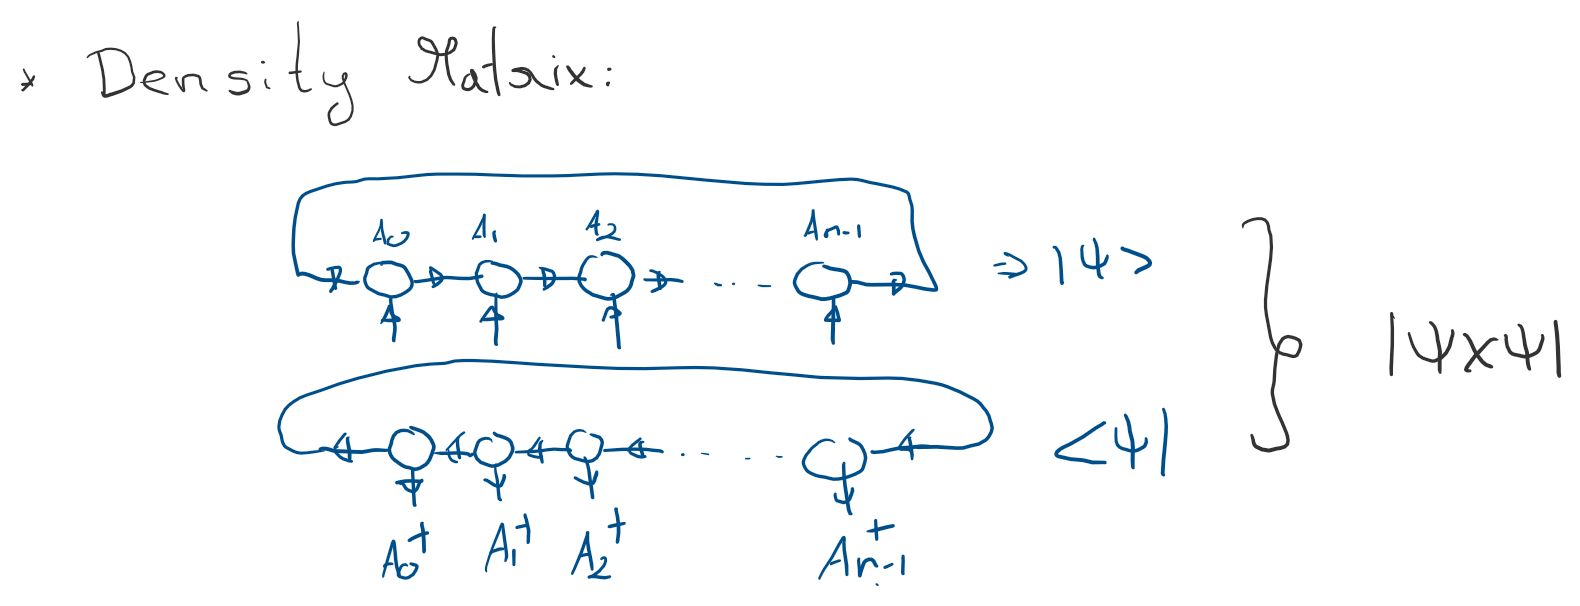

In [ ]:
[mps_.shape for mps_ in mps]

In [ ]:
# Naive Computation of density matrix: |Phi><Psi|
amp = np.array(pdf_zalo["Amplitude"])
amp = amp.reshape(amp.shape[0], 1)
rho0 = amp @ amp.conj().T

In [ ]:
# Computing Density Matrix using reduced_matrix for pure tensors
amp = np.array(pdf_zalo["Amplitude"])
amp = amp.reshape(tuple([2 for i in range(nqubits)]))
rho1 = tn.reduced_matrix(amp, [0, 1, 2, 3], [])

In [ ]:
#Testing both computations are equivalent
np.isclose(rho0, rho1).all()

## 3. Conputing Reduced Density Matrices from MPS

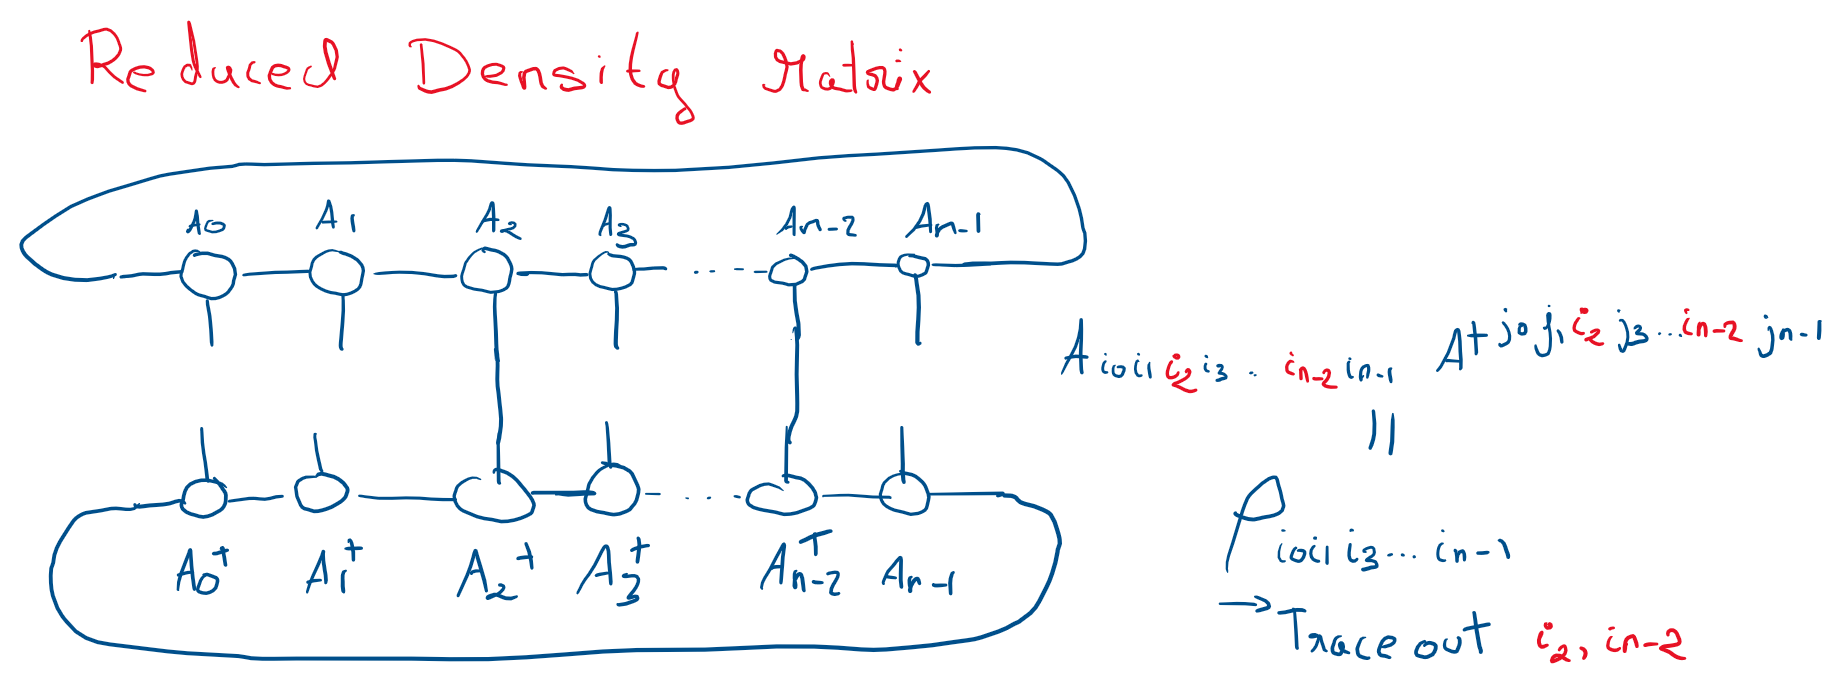


### 3.1 Site Operations

For each site we need to compute the corresponding operation. There are only two types of operation at each site:

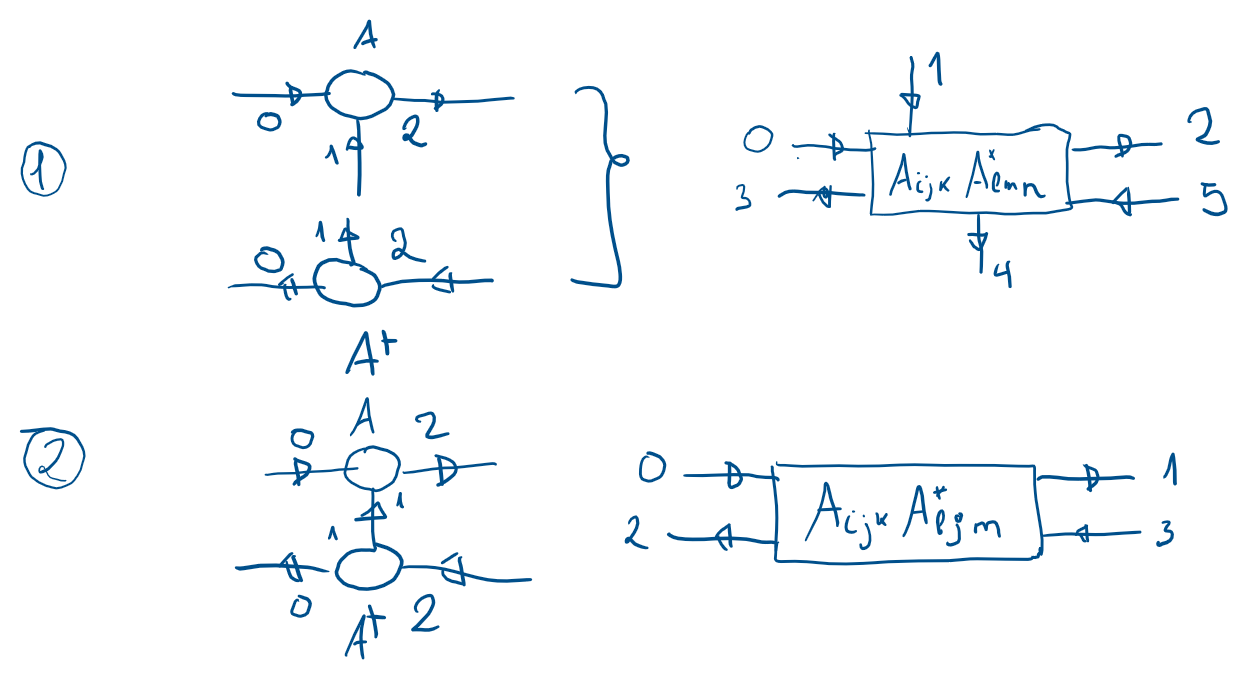


Tensor of type 1 are rank-6 tensro meanwhile type 2 are rank-4 tensors

In [ ]:
tensor = mps[0]
tensor_1 = contract_indices(tensor, tensor.conj(), [], [])

In [ ]:
tensor.shape, tensor_1.shape, tensor_1.ndim

In [ ]:
tensor = mps[1]
tensor_2 = contract_indices(tensor, tensor.conj(), [1], [1])

In [ ]:
tensor.shape, tensor_2.shape, tensor_2.ndim

### 3.2 Operation on 2 consecutive sites

Now we need a function that takes two consecutive site tensors and transform them into one tensor. Main idea is that the output tensor can be used in a recursive way with this function for computing the whole operation 8this is compute the complete reduced density matrix). This function is **density_matrix_mps_contracion**. 

The 2 psoible inputs can be only the 2 before tensor sites (see section 3.2). And there are four posible combinations:


In [ ]:
from tensornetworks import density_matrix_mps_contracion

#### Rank-6, Rank-4

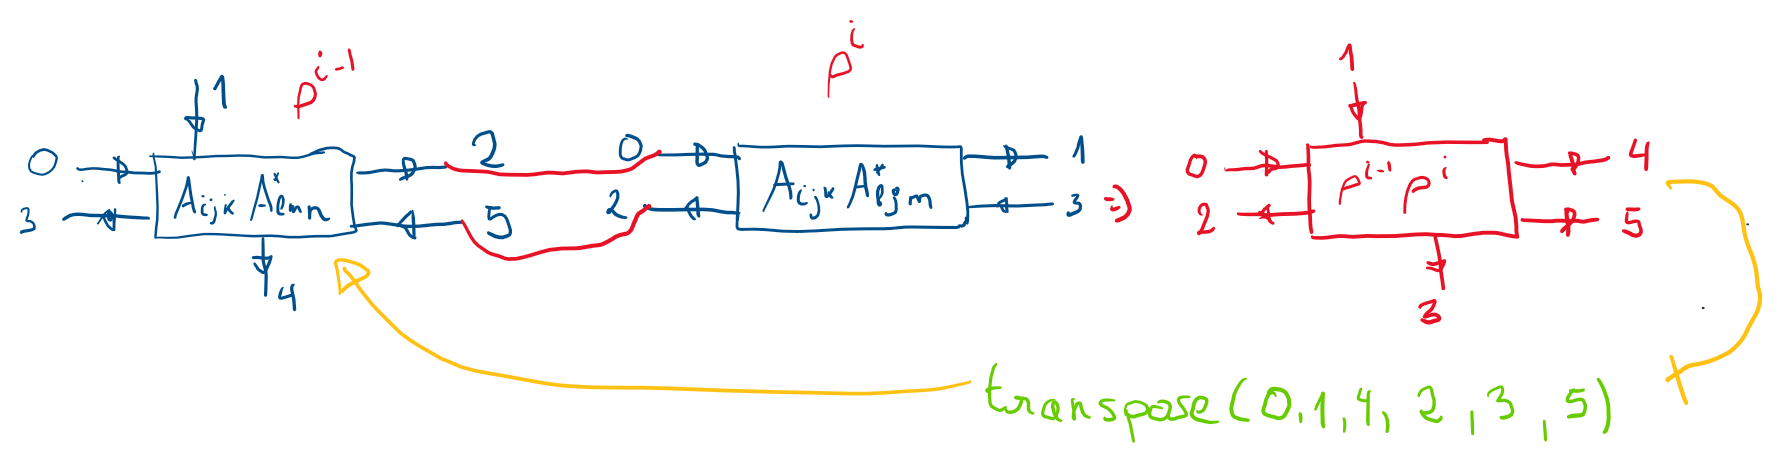

In [ ]:
tensor_out = density_matrix_mps_contracion(tensor_1, tensor_2)

In [ ]:
tensor_1.shape, tensor_2.shape, tensor_out.shape

In [ ]:
all([
    tensor_out.shape[0] == tensor_1.shape[0],
    tensor_out.shape[1] == tensor_1.shape[1],
    tensor_out.shape[2] == tensor_2.shape[1],
    tensor_out.shape[3] == tensor_1.shape[3],
    tensor_out.shape[4] == tensor_1.shape[4],
    tensor_out.shape[5] == tensor_2.shape[3],
])

#### Rank-4, Rank-4

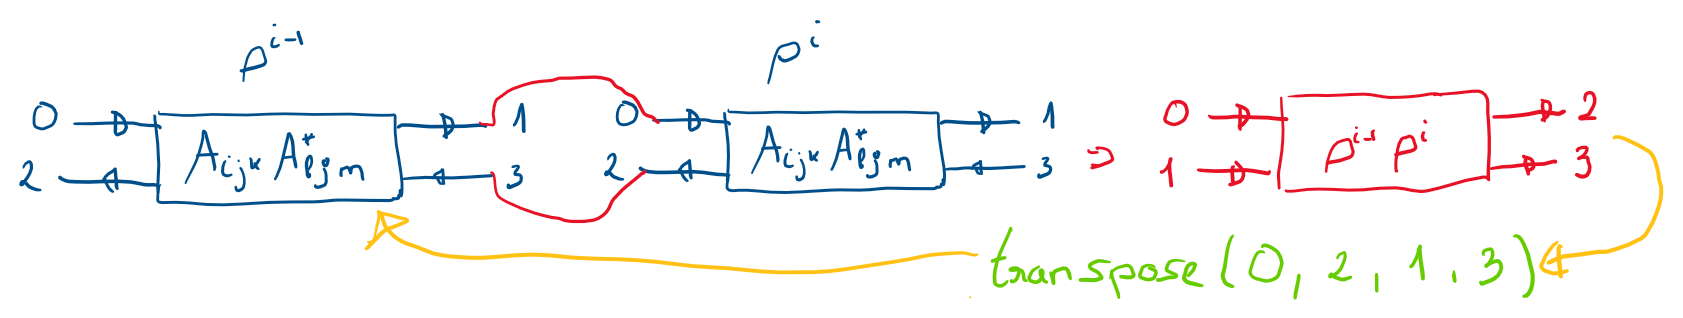

In [ ]:
tensor_case2_1 = tensor_2
tensor_case2_2 = tensor_2.transpose(1, 0, 3, 2)
tensor_out = density_matrix_mps_contracion(tensor_2, tensor_case2_2)

In [ ]:
tensor_case2_1.shape, tensor_case2_2.transpose(1, 0, 3, 2).shape, tensor_out.shape

In [ ]:
all([
    tensor_out.shape[0] == tensor_case2_1.shape[0],
    tensor_out.shape[1] == tensor_case2_1.shape[2],
    tensor_out.shape[3] == tensor_case2_2.shape[1],
    tensor_out.shape[3] == tensor_case2_2.shape[3]
])

#### Rank-4, Rank-6

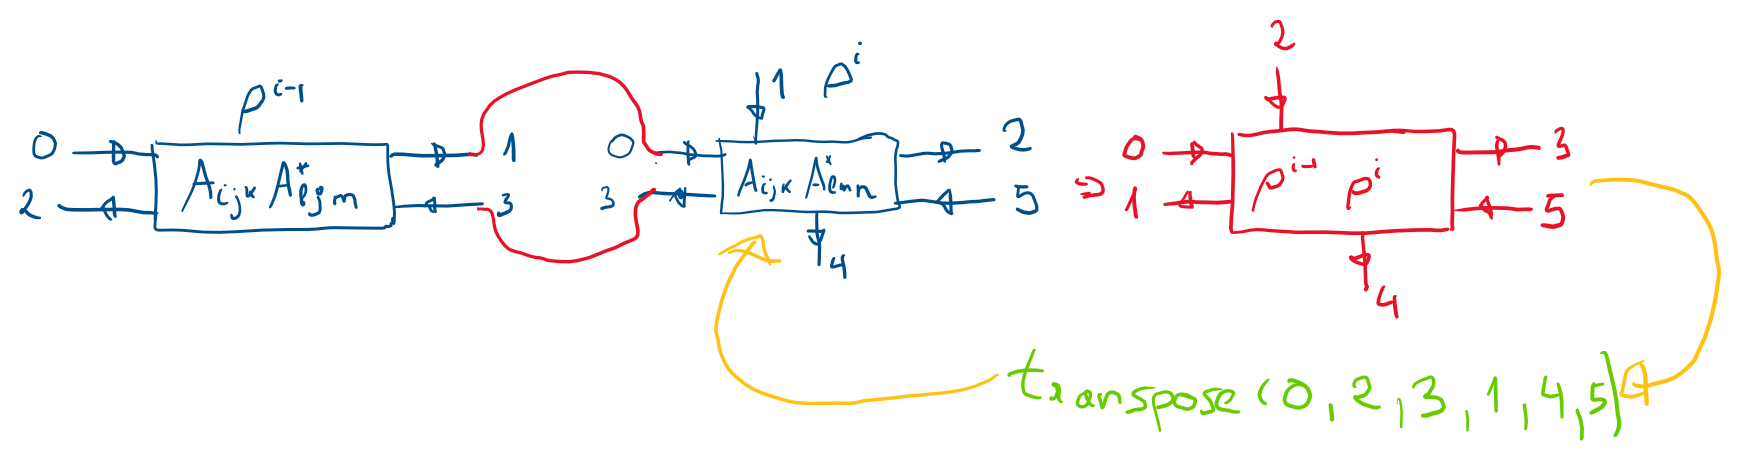

In [ ]:
tensor_case3_1 = tensor_2
tensor_case3_2 = tensor_1
tensor_out = density_matrix_mps_contracion(tensor_case3_1, tensor_case3_2)

In [ ]:
tensor_case3_1.shape, tensor_case3_2.shape, tensor_out.shape

In [ ]:
all([
    tensor_out.shape[0] == tensor_case3_1.shape[0],
    tensor_out.shape[1] == tensor_case3_2.shape[1],
    tensor_out.shape[2] == tensor_case3_2.shape[2],
    tensor_out.shape[3] == tensor_case3_1.shape[2],
    tensor_out.shape[4] == tensor_case3_2.shape[4],
    tensor_out.shape[5] == tensor_case3_2.shape[5]   
])

#### Rank-6, Rank-6

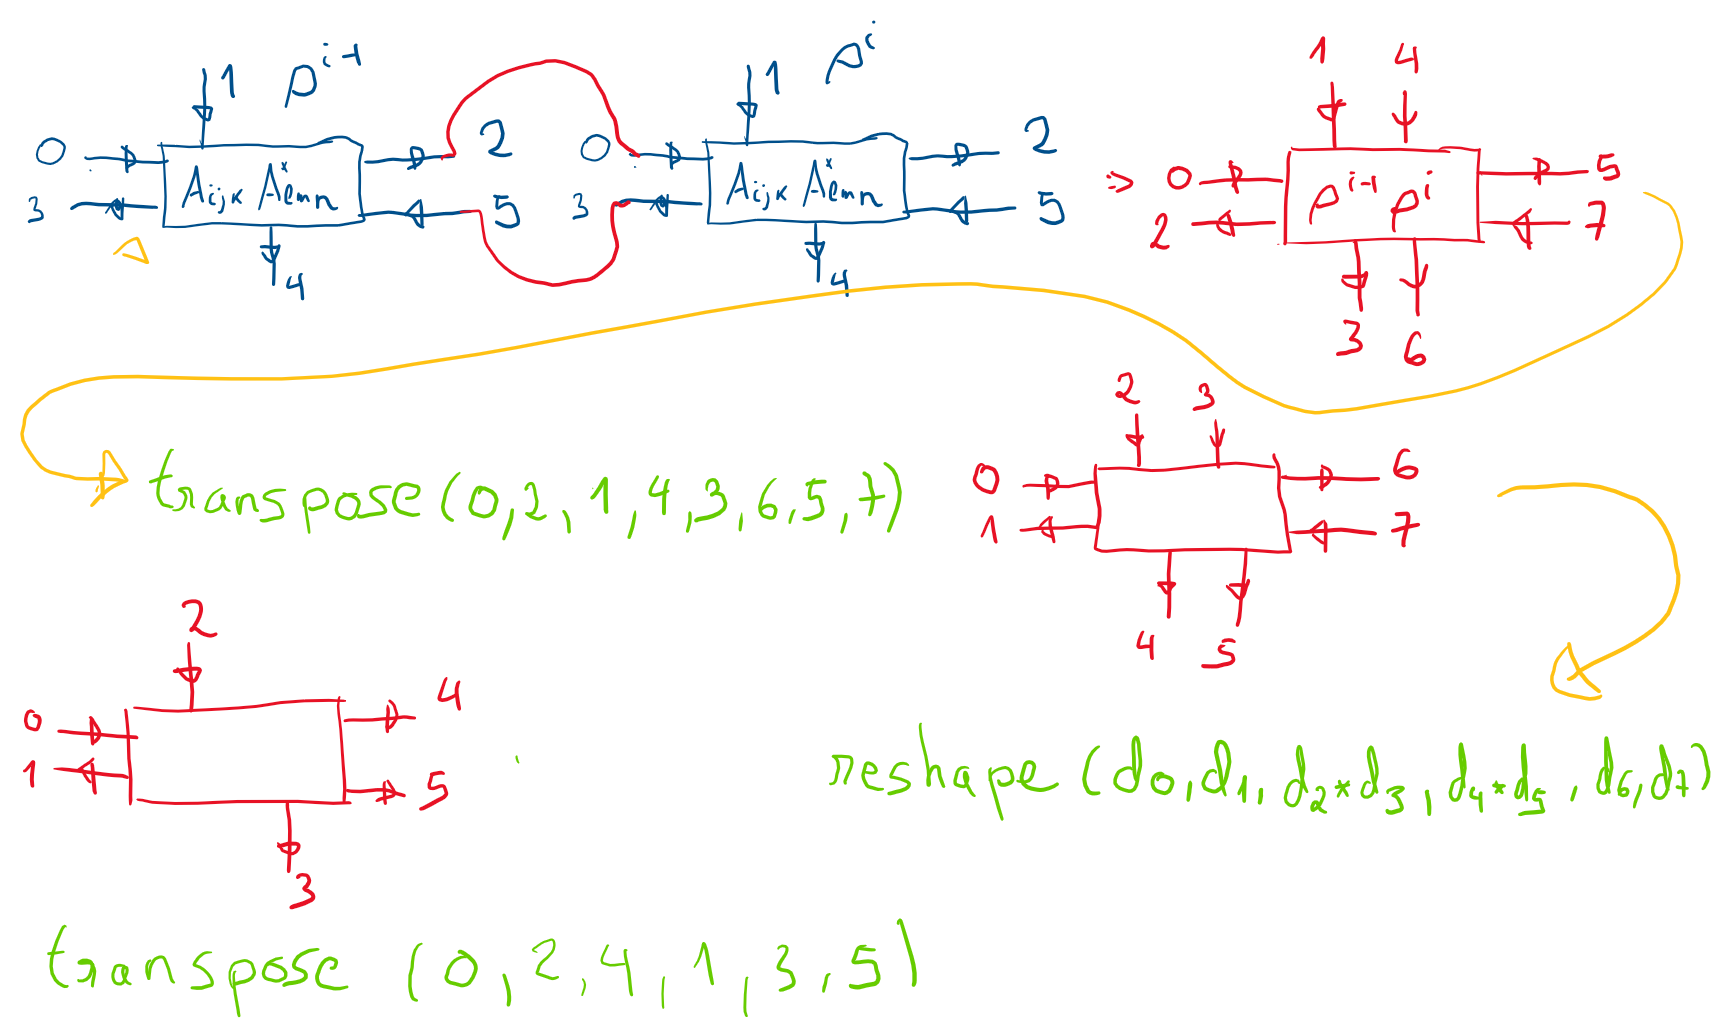

In [ ]:
tensor_case4_1 = tensor_1
tensor_case4_2 = tensor_1.transpose(2, 1, 0, 5, 4, 3)
tensor_out = density_matrix_mps_contracion(tensor_case4_1, tensor_case4_2)

In [ ]:
all([
    tensor_out.shape[0] == tensor_case4_1.shape[0],
    tensor_out.shape[1] == 2*tensor_case4_1.shape[1],
    tensor_out.shape[2] == tensor_case4_2.shape[2],
    tensor_out.shape[3] == tensor_case4_1.shape[3],
    tensor_out.shape[4] == 2 * tensor_case4_1.shape[4],
    tensor_out.shape[5] == tensor_case4_2.shape[5]
])

### 3.2 Computer pair contractions on a tensor.

As a last ingredient we need to compute in a tensor contraction ovr pair of indices. This is done using: **contract_indices_one_tensor**

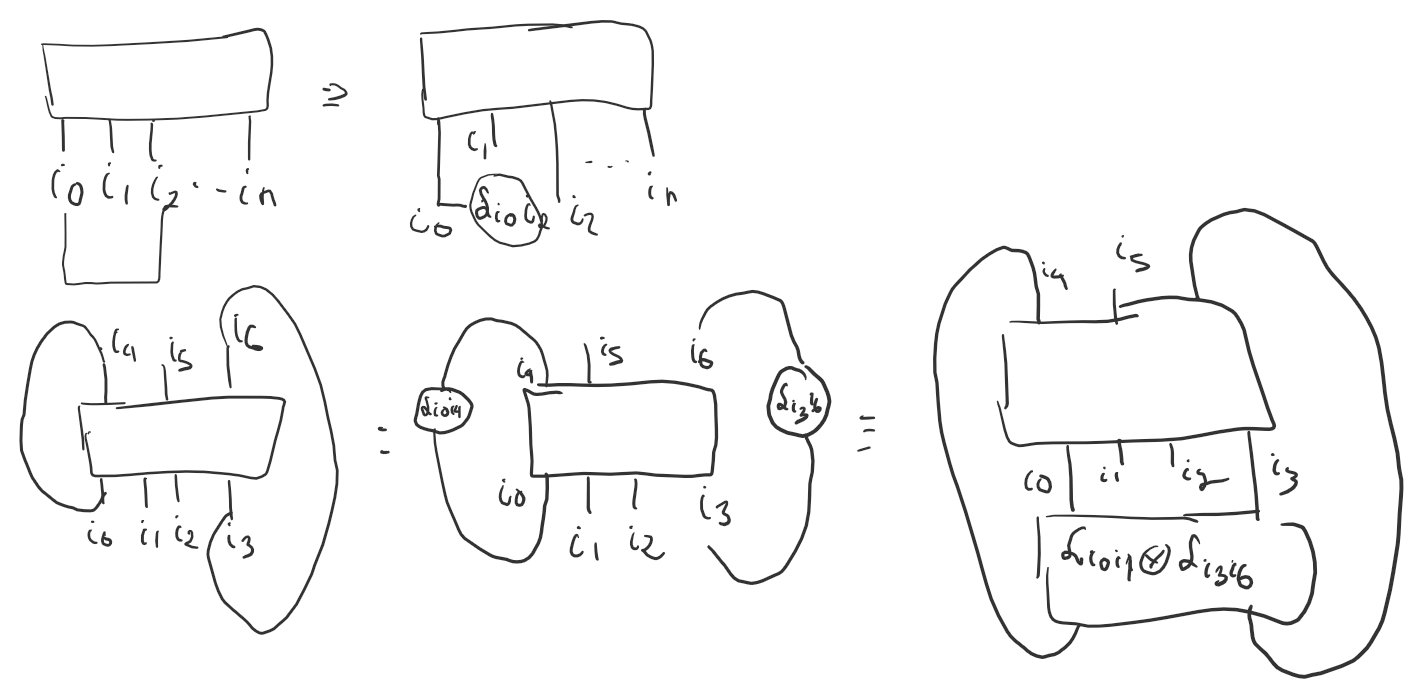

In [ ]:
tensor_1.shape

In [ ]:
np.isclose(
    np.einsum("AbcAde-> bcde", tensor_1),
    contract_indices_one_tensor(tensor_1, [(0, 3)])
).all()

In [ ]:
np.isclose(
    np.einsum("ABcABe-> ce", tensor_1),
    contract_indices_one_tensor(tensor_1, [(0, 3), (1, 4)])
).all()

In [ ]:
np.isclose(
    np.einsum("aAcdAe-> acde", tensor_1),
    contract_indices_one_tensor(tensor_1, [(1, 4)])
).all()

In [ ]:
np.isclose(
    np.einsum("aABdAB-> ad", tensor_1),
    contract_indices_one_tensor(tensor_1, [(1, 4), (2, 5)])
).all()

### 3.2 Computing using Zipper strategy

Finally we use the zipper strategy indicating which are the sites with no contraction (free) and with contraction

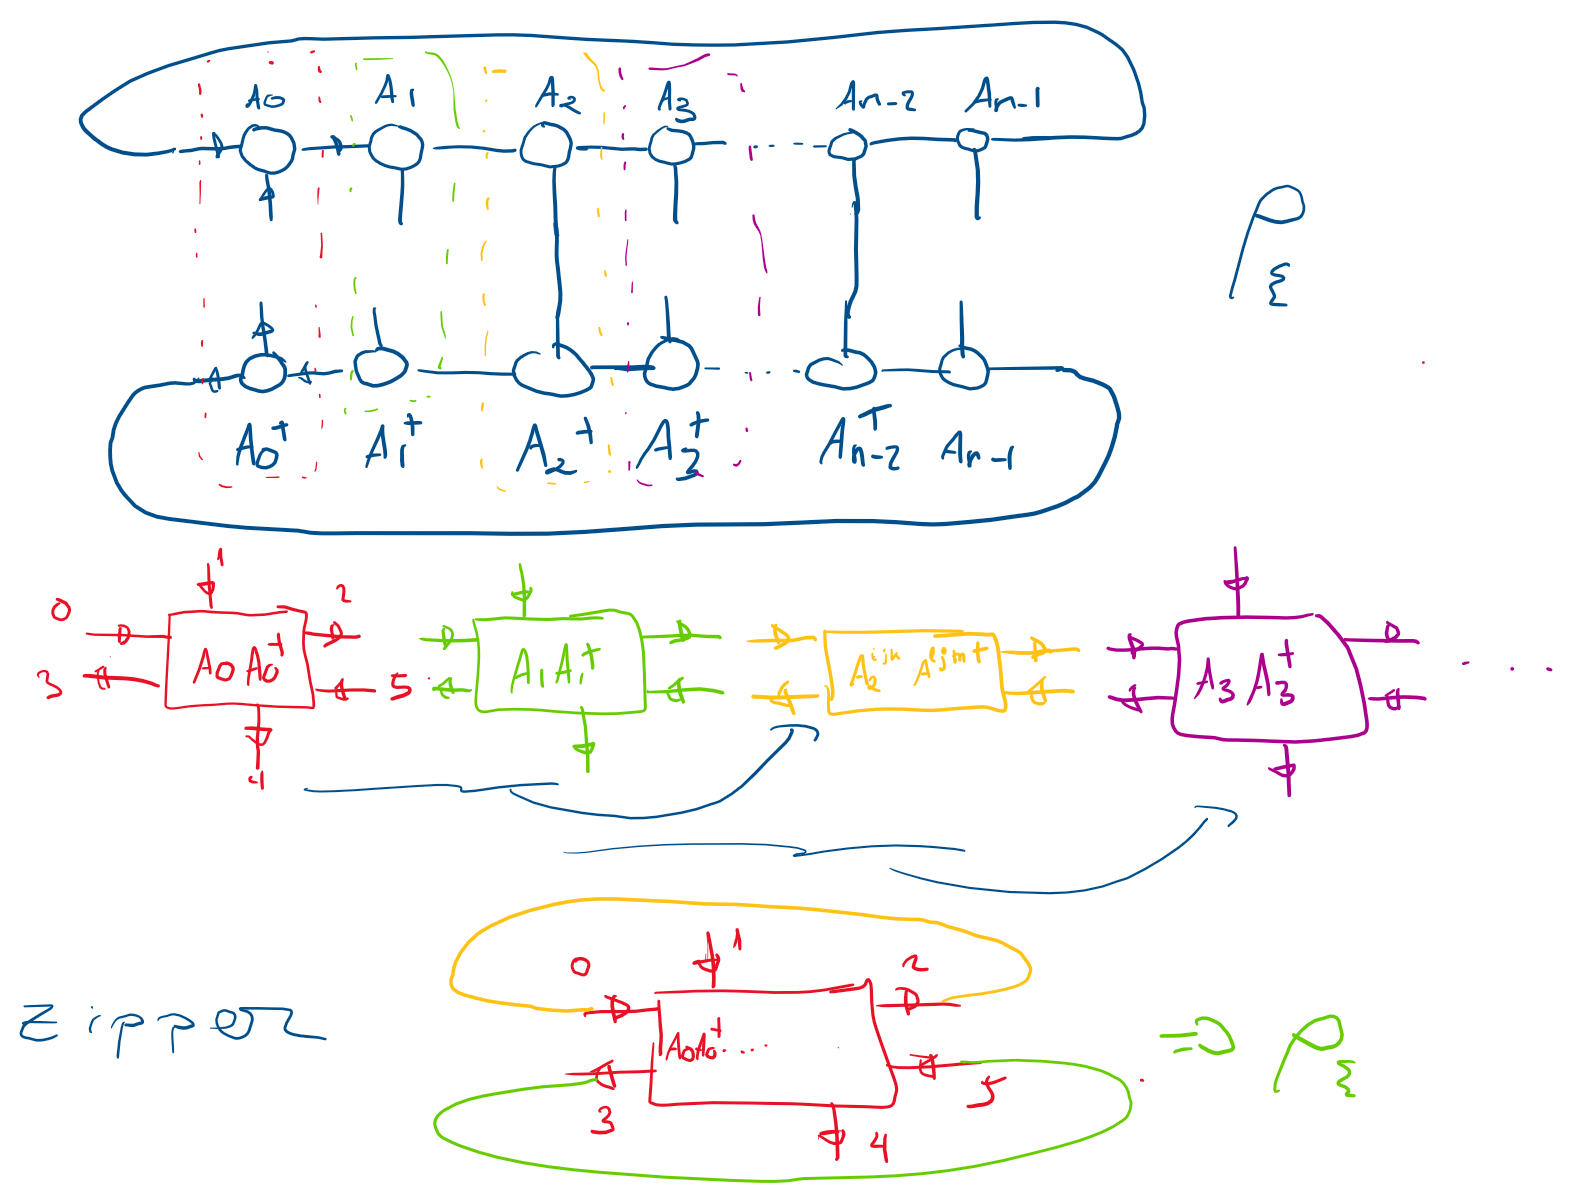

In [ ]:
def reduced_rho_mps(mps, free_indices, contraction_indices):
    i = 0
    tensor_out = mps[i]
    # Starting Tensor for Denisty Matrix
    
    if i in free_indices:
        tensor_out = contract_indices(tensor_out, tensor_out.conj(), [], [])
    elif i in contraction_indices:
        tensor_out = contract_indices(tensor_out, tensor_out.conj(), [1], [1])
    else:
        raise ValueError("Problem with site i: {}".format(i))
    
    for i in range(1, len(mps)):
        tensor = mps[i]
        if i in free_indices:
            tensor = contract_indices(tensor, tensor.conj(), [], [])
        elif i in contraction_indices:
            tensor = contract_indices(tensor, tensor.conj(), [1], [1])
        else:
            raise ValueError("Problem with site i: {}".format(i))        
        
        tensor_out = density_matrix_mps_contracion(tensor_out, tensor)
        
    tensor_out= contract_indices_one_tensor(tensor_out, [(0, 2), (3, 5)])
    
    return tensor_out   
    

In [ ]:
free = [0]
contraction = [1, 2, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 1]
contraction = [2, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 1, 2]
contraction = [3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 2]
contraction = [1, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 3]
contraction = [1, 2]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

## Computing Norm of the MPS

In [ ]:
def compute_norm(mps):
    tensor_out = mps[0]
    tensor_out = contract_indices(tensor_out, tensor_out.conj(), [0, 1], [0, 1])
    for tensor in mps[1:-1]:
        tensor_out = contract_indices(tensor_out, tensor, [0], [0])
        tensor_out = contract_indices(tensor_out, tensor.conj(), [0, 1], [0, 1])
    tensor = mps[-1]
    tensor_out = contract_indices(tensor_out, tensor, [0], [0])
    tensor_out = contract_indices(tensor_out, tensor.conj(), [0, 1, 2], [0, 1, 2])  
    return tensor_out

In [ ]:
compute_norm(mps)

In [ ]:
pdf_zalo["Amplitude"] @ np.conj(pdf_zalo["Amplitude"])